### coordinate-based meta-analysis

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from pathlib import Path
import json
from ontology_learner.coordinate_extraction.extraction_utils import get_sorted_coords
load_dotenv()
import nimare
from nimare.meta.cbma.mkda import MKDADensity
from nimare.dataset import Dataset
from nilearn.plotting import plot_stat_map
from nimare.correct import FWECorrector

datadir = Path(os.getenv('DATADIR'))
print(datadir)



/Users/poldrack/Dropbox/data/ontology-learner/data


Convert our datasets to nimare json files

In [58]:
# for now we use a default sample size of 20 for each contrast
# this needs to be fixed
def coord_df_to_nimare_json(coord_df):
    import logging
    logging.getLogger('nimare').setLevel(logging.WARNING)
    dset_dict= {}

    for pmid in coord_df.pmid.unique():
        ds_pmid = coord_df.query('pmid == @pmid')
        dset_dict[pmid] = {'contrasts': {}}
        for contrast in ds_pmid.contrast.unique():
            ds_contrast = ds_pmid.query('contrast == @contrast')
            if ds_contrast[['x', 'y', 'z']].values.shape[0] == 0:
                continue
            spaces = ds_contrast.coordinate_type.unique()
            if len(spaces) > 0:
                ds_space = spaces[0]
            else:
                ds_space = None
            if isinstance(ds_space, str):
                if 'mni' in ds_space.lower():
                    space = 'MNI'
                elif 'talairach' in ds_space.lower():
                    space = 'Talairach'
            else:
                space = None
            if space == 'Talairach':
                # convert to MNI
                coords = ds_contrast[['x', 'y', 'z']].values
                coords = nimare.utils.tal2mni(coords)
                ds_contrast.loc[:, 'x'] = coords[:, 0]
                ds_contrast.loc[:, 'y'] = coords[:, 1]
                ds_contrast.loc[:, 'z'] = coords[:, 2]
                space = 'MNI'
            dset_dict[pmid]['contrasts'][contrast] = {
                'coords':{
                    'x': ds_contrast.x.tolist(),
                    'y': ds_contrast.y.tolist(),
                    'z': ds_contrast.z.tolist(),
                    'space': "MNI"
                },
                'metadata': {
                    'sample_size': 20
                }
            }
    # convert keys to strings for JSON compatibility
    dset_dict = {str(k): v for k, v in dset_dict.items()}
    return dset_dict

for model in ['gpt4', 'llama3']:
    nimare_json_file = datadir / f'coordinate_extraction/{model}_nimare_dset.json'
    if not nimare_json_file.exists():
        dset_dict[model] = coord_df_to_nimare_json(coord_df_gpt4)
        with open(nimare_json_file, 'w') as f:
            json.dump(dset_dict[model], f)
    else:
        print(f"Loading {model} nimare json file from {nimare_json_file}")
        with open(nimare_json_file, 'r') as f:
            dset_dict[model] = json.load(f)



Loading gpt4 nimare json file from /Users/poldrack/Dropbox/data/ontology-learner/data/coordinate_extraction/gpt4_nimare_dset.json


### Overall meta-analysis on GPT-4o coordinates

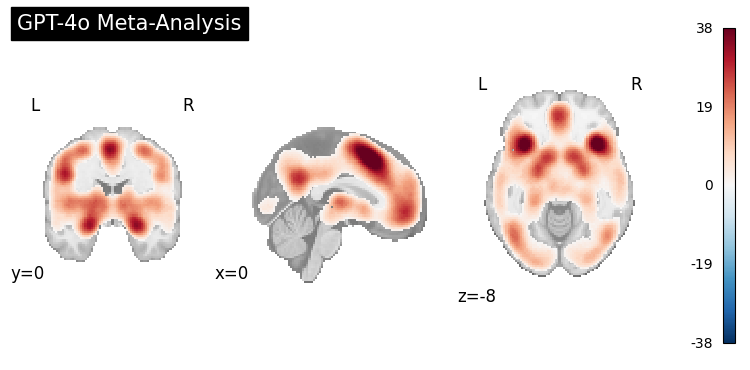

In [60]:

meta = MKDADensity()
dset = Dataset(dset_dict['gpt4'])
results_gpt4 = meta.fit(dset)

plot_stat_map(
    results_gpt4.get_map("z"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    symmetric_cbar=True,
    threshold=0.1,
    title=f"GPT-4o Meta-Analysis"
)

### Overall meta-analysis on Llama 3.3 coordinates

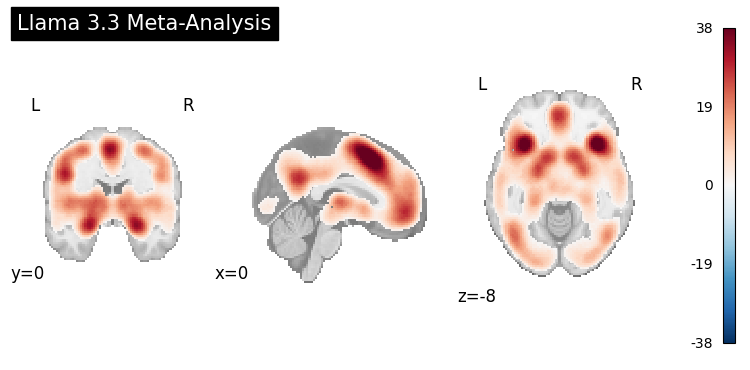

In [62]:
meta = MKDADensity()
dset = Dataset(dset_dict['llama3'])
results_llama3 = meta.fit(dset)

plot_stat_map(
    results_llama3.get_map("z"),
    cut_coords=[0, 0, -8],
    draw_cross=False,
    cmap="RdBu_r",
    symmetric_cbar=True,
    threshold=0.1,
    title=f"Llama 3.3 Meta-Analysis"
)